<h1>Gleichstrommaschine</h1>

<p>Betrachten wir eine Permanentmagnet-Gleichstrommaschine. Hier sind zunächst einmal die wichtigsten Parameter angegeben.</p>
<p>Ziel ist es, verschiedene Implementierungen eines Drehzahlregelsystems zu prüfen.</p>

In [ ]:
clear all
pkg load control

% Winding resistance
R = 1;

% Winding inductance
L = 0.5;

% EMF Constant
Vn = 200
K = 0.01

% Mechanincal Inertia
J = 0.01

%Mechanical losses
Km = 0.1


<p>Wir werden drei verschiedene Modelle betrachten:<br>
- Zustandsraum<br>
- Übertragungsfunktion unter der Annahme, dass keine mechanischen Verluste auftreten<br>
- Übertragungsfunktion mit der Annahme mechanischer Verluste</p>



In [ ]:
% Set the Octsim Engine to run the simulation
addpath('../Octsim');

% With mechanical losses
A = [-R/L -K/L; K/J -Km/J]
B = [1/L; 0]
C = [1 0; 0 1]
D = [0; 0]

% Without losses
num = [K/(L*J)]
den = [1 R/L K^2/(L*J)]

% With mechanical losses
num2 = [K/(L*J)]
den2 = [1 (Km/J+R/L) (R*Km+K*K)/(L*J)]

eigs(A)

<p>Hier führen wir den Ausgangsvektor zur Extraktion der Zustandsgeschwindigkeit und die Definition der beiden Übertragungsfunktionen ein.</p>

In [ ]:
Cd = [0 1]

Gs = tf(num,den)

Gs2 = tf(num2,den2)

<img src="figures/speeddia1.png" alt="drawing" width="600"  height="300"/>

<p>Der erste Entwurf ist eine PID-Regelung. Wir können ihn im Fall einer verlustfreien Übertragungsfunktion verwenden, bei der wir zwei Pole und keine Nullstellen haben. Die PID-Regelung wird zunächst dazu verwendet, die beiden Pole des Nenners der Übertragungsfunktion zu löschen.</p>

In [6]:
omo = 100;
Kd1 = omo/(num/den(1))
Kp1 = Kd1*den(2)/den(1)
Ki1 = Kd1*den(3)/den(1)

GrNum = [Kd1 Kp1 Ki1];
GrDen = [1 0];

Gr = tf(GrNum,GrDen);

Kd1 =  50
Kp1 =  100
Ki1 =  1


<p>Nun zeichnen wir die Übertragungsfunktion der Regelstrecke auf.</p>

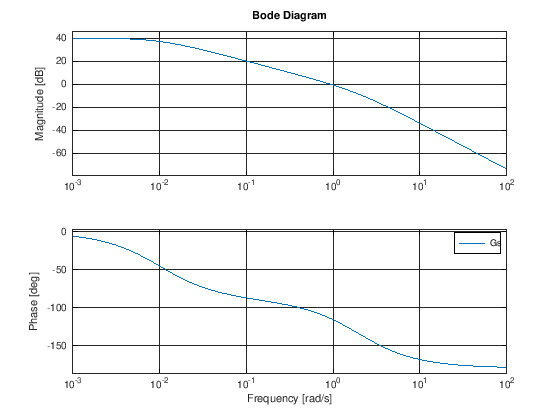

In [7]:
bode(Gs)

<p>Hier gilt umgekehrt die Übertragungsfunktion des offenen Regelkreises einschließlich des Reglers:</p>

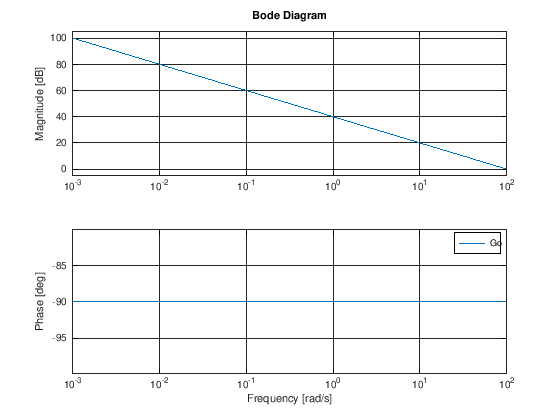

In [8]:
Go = Gs*Gr;
bode(Go)

<p>Nun die Übertragungsfunktion des offenen Regelkreises mit demselben Regler, wobei für die Regelstrecke die Übertragungsfunktion unter der Annahme von mechanischen Verlusten verwendet wird. Es ist interessant zu sehen, dass der Regler auch in diesem Fall eine gute Lösung ist, da die Verluste gering sind.</p>

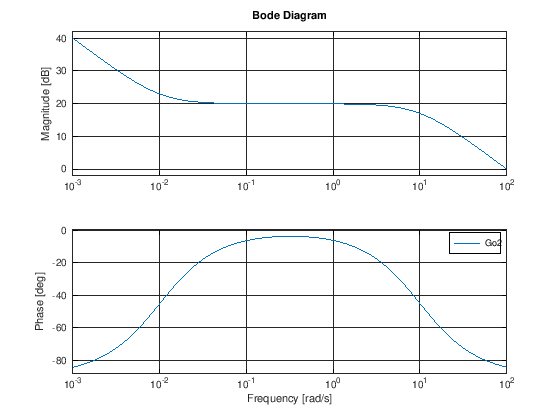

In [9]:
Go2 = Gs2*Gr;
bode(Go2)

<p>Die Ergebnisse werden mit einer Simulation einer Sprungantwort des geschlossenen Regelkreises verifiziert. Angesichts des hohen Wertes der Phasenreserve gibt es kein Überschwingen.</p>

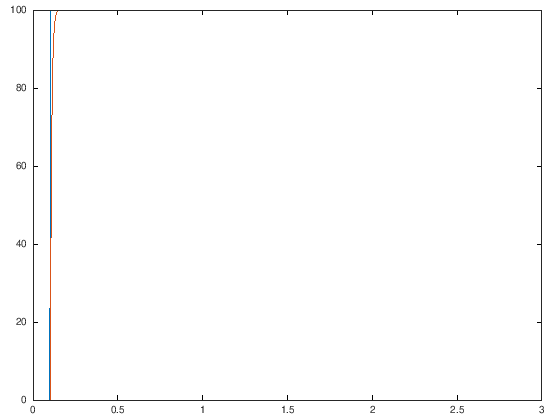

In [10]:
% Simulation Parameters
% Start time
tini = 0;
% End time
tfinal = 3;
% Time Step
dt = 0.001;
% Number of data flows in the schematic
nflows = 4;
% Sampling time for discrete time
Ts = 0.01;

% Instance of the simulation schematic
sc1 = Schema(tini,tfinal,dt,nflows);

% List of components
c1{1} = StepSource(1,0,100,0.1);
c1{2} = Sum(1,2,3,1,-1);
c1{3} = PID(3,4,Kp1,Ki1,Kd1,0);
c1{4} = TransferFunction(4,2,num,den);


sc1.AddListComponents(c1);

% Run the schematic and plot
out1 = sc1.Run([1 2]);
plot(out1(1,:),out1(2,:),out1(1,:),out1(3,:));
ylim([-5 105]);

<p>Als zweite Regelung entwerfen wir einen PI-Regler. In diesem Fall benötigen wir zwei Spezifikationen: Bandbreite und Phasenreserve</p>

In [11]:
omo = 1;
Fideg = 60;
Fi = Fideg*pi/180;

[Go Fo]= bode(Gs,omo)
Fo = Fo*pi/180;

Kp2 = cos(-pi+Fi-Fo)/Go
Ki2 = -sin(-pi+Fi-Fo)*omo/Go

Go =  0.89799
Fo = -116.10
Kp2 =  1.1110
Ki2 =  0.075648



Transfer function 'Gr2' from input 'u1' to output ...

      1.111 s + 0.07565
 y1:  -----------------
              s        

Continuous-time model.

Transfer function 'Go' from input 'u1' to output ...

        2.222 s + 0.1513  
 y1:  --------------------
      s^3 + 2 s^2 + 0.02 s

Continuous-time model.


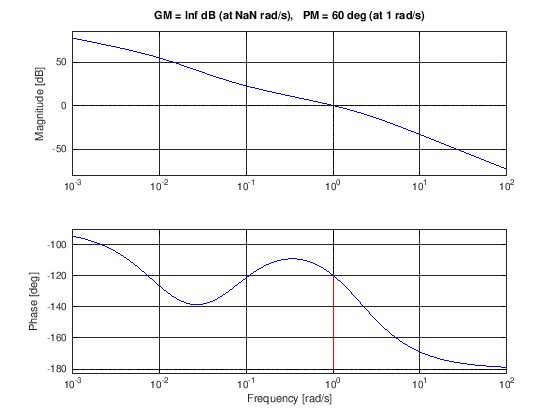

In [12]:
NumGr = [Kp2 Ki2];
DenGr = [1 0];
Gr2 = tf(NumGr,DenGr)
Go = Gs*Gr2
margin(Go)

<p>Jetzt kommt es zu einem Überschwingen, da die Phasenreserve klein ist.</p>

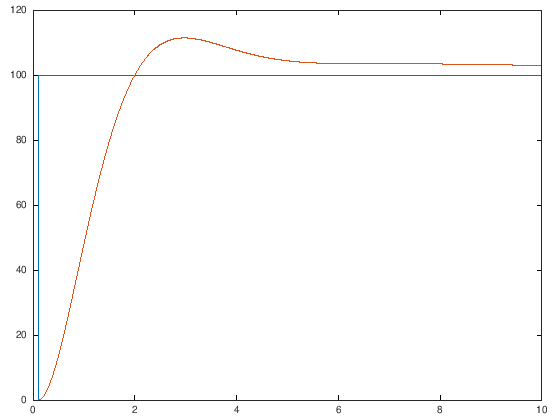

In [13]:
% Simulation Parameters
% Start time
tini = 0;
% End time
tfinal = 10;
% Time Step
dt = 0.001;
% Number of data flows in the schematic
nflows = 4;

% Instance of the simulation schematic
sc2 = Schema(tini,tfinal,dt,nflows);

% List of components
c2{1} = StepSource(1,0,100,0.1);
c2{2} = Sum(1,2,3,1,-1);
c2{3} = PI(3,4,Kp2,Ki2,0);
c2{4} = TransferFunction(4,2,num,den);


sc2.AddListComponents(c2);

% Run the schematic and plot
out2 = sc2.Run([1 2]);
plot(out2(1,:),out2(2,:),out2(1,:),out2(3,:));

<p>Umgekehrt funktioniert der ohne Verluste entworfene PID erwartungsgemäß auch, aber nicht perfekt. Die Polauslöschung ist nicht perfekt, und dies ist sichtbar.</p>

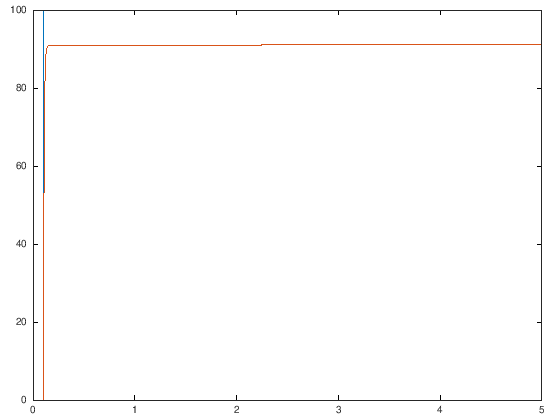

In [14]:
% Number of data flows in the schematic
nflows2 = 4;

tfinal2 = 5;

% Instance of the simulation schematic
sca = Schema(tini,tfinal2,dt,nflows2);

xo = [0; 0];

% List of components
ca{1} = StepSource(1,0,100,0.1);
ca{2} = Sum(1,2,3,1,-1);
ca{3} = PID(3,4,Kp1,Ki1,Kd1,0);
ca{4} = StateSpace(4,2,A,B,Cd,0,xo);

sca.AddListComponents(ca);

% Run the schematic and plot
out3 = sca.Run([1 2]);
plot(out3(1,:),out3(2,:),out3(1,:),out3(3,:));
ylim([-5 105]);

<p>Wir betrachten nun die Implementierung eines digitalen Reglers. Zunächst einmal führen wir einfach den gleichen Entwurf wie bei einem analogen Regler aus. Zu Beginn wählen wir die Abtastzeit als Funktion der Eigenwerte der Regelstrecke.</p>

In [15]:
pa = roots(den)

pa =

  -1.989949
  -0.010051



In [16]:
tau = min(-1./real(pa))
Ts = tau/10

tau =  0.50253
Ts =  0.050253


<p>Dann können wir die Koeffizienten für den digitalen PI-Regler berechnen:</p>

In [17]:
Kr = Kp2;
Ti = Kr/Ki2;

Zn = 1/(1+Ts/Ti);

Numrz = [Kr/Zn -Kr];
Denrz = [1 -1];


Transfer function 'Grz' from input 'u1' to output ...

      1.115 z - 1.111
 y1:  ---------------
           z - 1     

Sampling time: 0.0502525 s
Discrete-time model.

Transfer function 'Gsz' from input 'u1' to output ...

      0.002443 z + 0.002362 
 y1:  ----------------------
      z^2 - 1.904 z + 0.9044

Sampling time: 0.0502525 s
Discrete-time model.


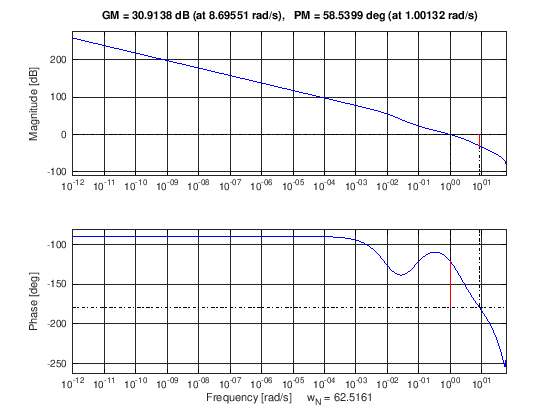

In [18]:
Grz = tf(Numrz,Denrz,Ts)
Gsz = c2d(Gs,Ts,'zoh')

Go3 = Grz*Gsz;
margin(Go3)

<p>Mit dieser Formel erhalten wir einen Näherungswert für den Verlust an Phasenreserve, der durch die Diskretisierung entsteht. Angesichts des erhaltenen Wertes können wir davon ausgehen, dass die Schwingung größer sein wird.</p>

In [19]:
DeltaFim = (omo*Ts/2)*180/pi

DeltaFim =  1.4396


<p>Die Simulation bestätigt das Ergebnis:</p>

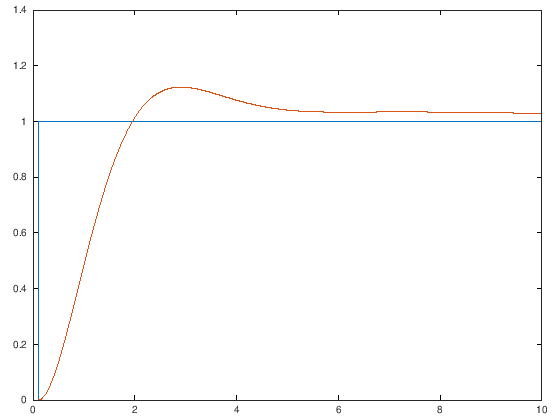

In [20]:
% Number of data flows in the schematic
nflows = 4;

% Instance of the simulation schematic
sc3 = Schema(tini,tfinal,dt,nflows);

% List of components
c3{1} = StepSource(1,0,1,0.1);
c3{2} = Sum(1,2,3,1,-1);
c3{3} = DTTransferFunction(3,4,Numrz,Denrz,Ts);
c3{4} = TransferFunction(4,2,num,den);


sc3.AddListComponents(c3);

% Run the schematic and plot
out3 = sc3.Run([1 2]);
plot(out3(1,:),out3(2,:),out3(1,:),out3(3,:));

<p>Eine direkte Auslegung in der Z-Ebene ist ebenfalls möglich.</p>

In [21]:
G1z = c2d(Gs,Ts,'zoh')
omb = 1
fim = 60

[Gw fi] = bode(G1z,omb)
th = -180+fim-fi

Kp3 = cos(th*pi/180)/Gw
Ki3 = -sin(th*pi/180)*omb/Gw


Transfer function 'G1z' from input 'u1' to output ...

      0.002443 z + 0.002362 
 y1:  ----------------------
      z^2 - 1.904 z + 0.9044

Sampling time: 0.0502525 s
Discrete-time model.
omb =  1
fim =  60
Gw =  0.89790
fi = -117.54
th = -2.4555
Kp3 =  1.1127
Ki3 =  0.047716


In [22]:
KiT = Ki3*Ts/2

n1 = Kp3+KiT
n2 = KiT-Kp3

Numrz2 = [n1 n2];
Denrz2 = [1 -1];
Gr1 = tf(Numrz2,Denrz2,Ts)

KiT =  0.0011989
n1 =  1.1139
n2 = -1.1115

Transfer function 'Gr1' from input 'u1' to output ...

      1.114 z - 1.111
 y1:  ---------------
           z - 1     

Sampling time: 0.0502525 s
Discrete-time model.


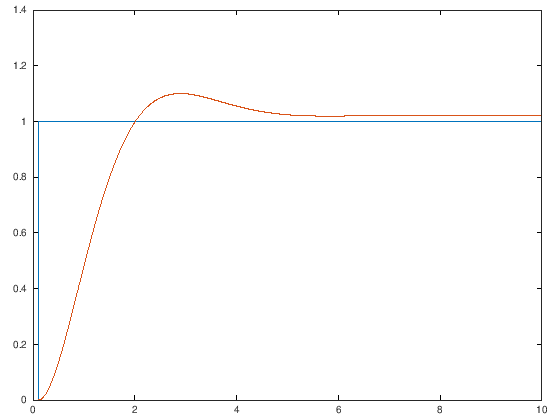

In [23]:
% Number of data flows in the schematic
nflows = 4;

% Instance of the simulation schematic
sc4 = Schema(tini,tfinal,dt,nflows);

% List of components
c4{1} = StepSource(1,0,1,0.1);
c4{2} = Sum(1,2,3,1,-1);
c4{3} = DTTransferFunction(3,4,Numrz2,Denrz2,Ts);
c4{4} = TransferFunction(4,2,num,den);


sc4.AddListComponents(c4);

% Run the schematic and plot
out4 = sc4.Run([1 2]);
plot(out4(1,:),out4(2,:),out4(1,:),out4(3,:));

Eine weitere Möglichkeit, PI zu verwenden und gute Leistungen zu erzielen, besteht in der Definition einer kaskadierten Regelungsarchitektur: eine interne Stromregelung und eine externe Drehzahlregelung. Wir führen nun sowohl Strom als auch Geschwindigkeit zurück. Beachten Sie, dass durch die Messung beider Größen der Entwurf einfacher und effizienter wird.</p>

<img src="figures/speeddia2.png" alt="drawing" width="600"  height="300"/><p>

In [24]:
%PI Current
omc =  200
Kpc = omc/(1/L)
Kic = Kpc*R/L

oms = 20
Kps = oms/(K/J)
Kis = Kps*Km/J


omc =  200
Kpc =  100
Kic =  200
oms =  20
Kps =  20
Kis =  200


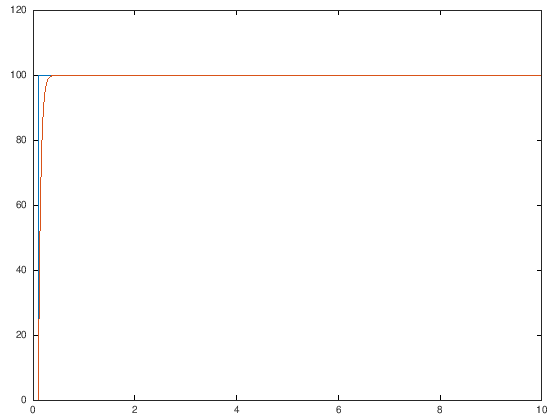

In [25]:
% Number of data flows in the schematic
nflows2 = 9;

% Instance of the simulation schematic
sc5 = Schema(tini,tfinal,dt,nflows2);

% List of components
c5{1} = StepSource(1,0,100,0.1);
c5{2} = Sum(1,2,3,1,-1);
c5{3} = PI(3,4,Kps,Kis,0);
c5{4} = Sum(4,5,6,1,-1);
c5{5} = PI(6,7,Kpc,Kic,0);
c5{6} = Sum(7,8,9,1,1);
c5{7} = Gain(2,8,K);
c5{8} = StateSpace(9,[5, 2],A,B,C,D,xo);



sc5.AddListComponents(c5);

% Run the schematic and plot
out5 = sc5.Run([1 2]);
plot(out5(1,:),out5(2,:),out5(1,:),out5(3,:));
ylim([-5 105]);

<p>Als letzte Option kommt auch ein Deadbeat-Regler vierter Ordnung in Betracht.</p>

In [32]:
Ts2 = Ts;
G2z = c2d(Gs,Ts2,'zoh')
numG = cell2mat(G2z.num)
denG = cell2mat(G2z.den)

b1 = sum(numG)

numd = denG
dend= conv(numG,[1 0 0 0 -1])

Gr2 = tf(numd,dend,Ts2)


Transfer function 'G2z' from input 'u1' to output ...

      0.002443 z + 0.002362 
 y1:  ----------------------
      z^2 - 1.904 z + 0.9044

Sampling time: 0.0502525 s
Discrete-time model.
numG =

   0.0024428   0.0023623

denG =

   1.00000  -1.90433   0.90438

b1 =  0.0048051
numd =

   1.00000  -1.90433   0.90438

dend =

   0.0024428   0.0023623   0.0000000   0.0000000  -0.0024428  -0.0023623


Transfer function 'Gr2' from input 'u1' to output ...

                    z^2 - 1.904 z + 0.9044               
 y1:  ---------------------------------------------------
      0.002443 z^5 + 0.002362 z^4 - 0.002443 z - 0.002362

Sampling time: 0.0502525 s
Discrete-time model.


<p>Wir überprüfen dann per Simulation:</p>

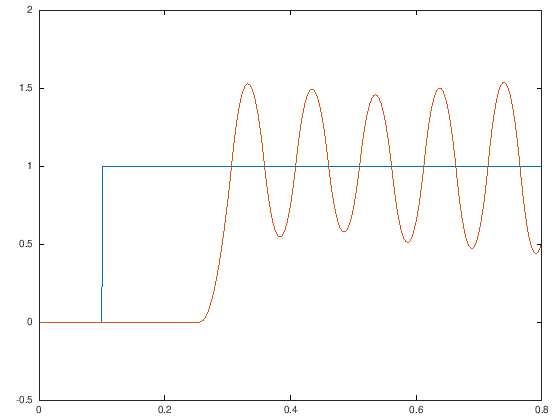

In [41]:
% Number of data flows in the schematic
nflows = 4;
tfinal3 = 0.8;


% Instance of the simulation schematic
sc6 = Schema(tini,tfinal3,dt,nflows);

% List of components
c6{1} = StepSource(1,0,1,0.1);
c6{2} = Sum(1,2,3,1,-1);
c6{3} = DTTransferFunction(3,4,numd,dend,Ts2);
c6{4} = TransferFunction(4,2,num,den);


sc6.AddListComponents(c6);

% Run the schematic and plot
out6 = sc6.Run([1 2 3]);
plot(out6(1,:),out6(2,:),out6(1,:),out6(3,:));

<p>Die Ergebnisse sind nicht gut und weisen eine zunehmende Schwankung auf. Dies ist ein Phänomen, das bei Deadbeat-Controllern auftreten kann. Es kann überprüft werden, dass der Fehler zum Zeitpunkt der Abtastung eigentlich 0 ist, aber dann kommt es zu einer Oszillation, die hier tatsächlich auch divergiert.
Andererseits ist der Entwurf korrekt, wie die Berechnung der Übertragungsfunktion des geschlossenen Regelkreises zeigt.
Es sind spezielle Lösungen erforderlich, um das Oszillationsproblem in dem System, in dem es auftritt, zu beseitigen.</p>

In [42]:
Gl = Gr2*G1z;
Gcl = Gl/(1+Gl);
Gcl = minreal(Gcl)


Transfer function 'Gcl' from input 'u1' to output ...

       1 
 y1:  ---
      z^4

Sampling time: 0.0502525 s
Discrete-time model.


<p>Mit mechanischen Verlusten ist die Situation aber schon besser.</p>

In [43]:
G3z = c2d(Gs2,Ts2,'zoh')
numG2 = cell2mat(G3z.num)
denG2 = cell2mat(G3z.den)

b12 = sum(numG2)

numd2 = denG2
dend2= conv(numG2,[1 0 0 0 -1])

Gr3 = tf(numd2,dend2,Ts2)


Transfer function 'G3z' from input 'u1' to output ...

      0.002077 z + 0.001699 
 y1:  ----------------------
      z^2 - 1.509 z + 0.5472

Sampling time: 0.0502525 s
Discrete-time model.
numG2 =

   0.0020774   0.0016995

denG2 =

   1.00000  -1.50934   0.54715

b12 =  0.0037769
numd2 =

   1.00000  -1.50934   0.54715

dend2 =

   0.0020774   0.0016995   0.0000000   0.0000000  -0.0020774  -0.0016995


Transfer function 'Gr3' from input 'u1' to output ...

                    z^2 - 1.509 z + 0.5472               
 y1:  ---------------------------------------------------
      0.002077 z^5 + 0.001699 z^4 - 0.002077 z - 0.001699

Sampling time: 0.0502525 s
Discrete-time model.


In [44]:
% Instance of the simulation schematic
sc7 = Schema(tini,tfinal3,dt,nflows);

% List of components
c7{1} = StepSource(1,0,1,0.1);
c7{2} = Sum(1,2,3,1,-1);
c7{3} = DTTransferFunction(3,4,numd2,dend2,Ts2);
c7{4} = TransferFunction(4,2,num2,den2);


sc7.AddListComponents(c7);

% Run the schematic and plot
out7 = sc7.Run([1 2 3]);
plot(out7(1,:),out7(2,:),out7(1,:),out7(3,:));